# Sugestie
* ip embedding
* target encoding
* bucketing
* hash semantyczny
* isolation forest / SVM
* pca



# Przygotowanie danych

In [39]:

from sympy import Integer
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import hashlib

## Import danych

In [40]:
# url = 'https://raw.githubusercontent.com/wiktorDeka/WykrywanieAnomalii/main/reduced_dataset_sdn.csv'
url = 'https://raw.githubusercontent.com/wiktorDeka/WykrywanieAnomalii/main/dataset_sdn.csv'
s = requests.get(url).content

counters = pd.read_csv(io.StringIO(s.decode('utf-8')))
counters.dt = pd.to_datetime(counters.dt, unit='s')
counters.set_index('dt', inplace=True)

## Przygotowanie danych – brakujące dane

Usunięcie całych obserwacji w których występuje brak danych. Często metodę określa się z angielskiego jako complete-case analysis (CCA), czyli analizie poddajemy tylko te obserwacje dla których mamy pełne dane dla wszystkich zmiennych. W naszym przypadku z uwagi na relatywnie niską liczebność, postanowiliśmy braki pominąć.

In [41]:
counters.dropna(inplace=True)
counters.isnull().sum()


switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64

## Przygotowanie danych - kodowanie zmiennych kategorialnych

Dla przypomnienia zmienna kategorialna to taka, która pozwala na przeprowadzenie klasyfikacji serii danych za pomocą wartości związanych z określoną jakością czy kategorią. Zmienna kategorialna pozwala sklasyfikować, pogrupować w oparciu o informację jakościową, czyli najczęściej w danych spotkamy zmienną kategorialną z elementami stanowiącymi łańcuch tekstowy. W naszym przypadku będziemy zaliczać do zmiennych kategorialnych : data/czas danych wpisów, nazwa protokołu jaki został uzyty, destination i source adresy.

Na podstawie róznych benchamrków, mozemy się skupić na tych 4 enkoderach.

"We observed that four encoders: One-Hot, Binary (‘Bin’ on the plot), Sum, and Weight of Evidence are consistently among the best performing. For logistic regression, the difference of these four from the rest is statistically significant."


## Przygotowanie danych - duration

Łączymy duration_sec i duration_nsec, aby otrzymać pełny czas trwania - duration.


In [42]:
# Create the new 'duration' column

if 'dur' in counters and 'dur_nsec' in counters:
  counters['duration'] = counters['dur'] + counters['dur_nsec'] / 1e9

  # Drop the 'duration_sec' and 'duration_nsec' columns
  counters = counters.drop(['dur', 'dur_nsec'], axis=1)

counters.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103839 entries, 1970-01-01 03:10:25 to 1970-01-01 01:27:42
Data columns (total 21 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   switch       103839 non-null  int64  
 1   src          103839 non-null  object 
 2   dst          103839 non-null  object 
 3   pktcount     103839 non-null  int64  
 4   bytecount    103839 non-null  int64  
 5   tot_dur      103839 non-null  float64
 6   flows        103839 non-null  int64  
 7   packetins    103839 non-null  int64  
 8   pktperflow   103839 non-null  int64  
 9   byteperflow  103839 non-null  int64  
 10  pktrate      103839 non-null  int64  
 11  Pairflow     103839 non-null  int64  
 12  Protocol     103839 non-null  object 
 13  port_no      103839 non-null  int64  
 14  tx_bytes     103839 non-null  int64  
 15  rx_bytes     103839 non-null  int64  
 16  tx_kbps      103839 non-null  int64  
 17  rx_kbps      103839 non-null  flo

## Normalizacja

Normalizacja to proces przekształcania danych wejściowych w taki sposób, aby poprawić wydajność modelu uczącego się. Głównym celem normalizacji jest doprowadzenie danych do jednolitej skali lub rozkładu, co może ułatwić uczenie modelu poprzez zmniejszenie wpływu różnic w zakresach lub jednostkach między różnymi cechami danych.

Istnieje kilka popularnych metod normalizacji danych, takich jak:

Normalizacja min-max: Skaluje wartości cech do zakresu między 0 a 1, wykorzystując minimum i maksimum wartości danej cechy.
Z-score normalization (StandardScaler): Przekształca wartości cech tak, aby miały średnią równą zero i odchylenie standardowe równe jeden.
Normalizacja jednostkowa: Polega na dzieleniu każdej wartości cechy przez normę wektora cechy, co prowadzi do przeskalowania cech do jednostkowego wektora o długości 1.

In [43]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'counters' is your DataFrame
columns_to_normalize = ['pktcount', 'bytecount', 'tx_bytes', 'rx_bytes']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
counters[columns_to_normalize] = scaler.fit_transform(counters[columns_to_normalize])
counters

,switch,src,dst,pktcount,bytecount,tot_dur,flows,packetins,pktperflow,byteperflow,...,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,duration
dt,,,,,,,,,,,,,,,,,,,,,
1970-01-01 03:10:25,1,10.0.0.1,10.0.0.8,0.174242,0.328245,1.010000e+11,3,1943,13535,14428310,...,0,UDP,3,1.133295e-01,3.090061e-06,0,0.0,0.0,0,100.716
1970-01-01 03:13:25,1,10.0.0.1,10.0.0.8,0.486123,0.915781,2.810000e+11,2,1943,13531,14424046,...,0,UDP,4,1.035450e-06,2.689292e-06,0,0.0,0.0,0,280.734
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,0.347427,0.654498,2.010000e+11,3,1943,13534,14427244,...,0,UDP,1,9.984414e-07,3.896647e-07,0,0.0,0.0,0,200.744
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,0.347427,0.654498,2.010000e+11,3,1943,13534,14427244,...,0,UDP,2,9.141880e-07,6.420382e-07,0,0.0,0.0,0,200.744
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,0.347427,0.654498,2.010000e+11,3,1943,13534,14427244,...,0,UDP,3,6.976491e-07,2.835669e-06,0,0.0,0.0,0,200.744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,0.000304,0.000053,8.184200e+10,5,10,29,2842,...,0,ICMP,1,9.985988e-06,1.197664e-05,1,1.0,2.0,0,81.842
1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,0.000304,0.000053,8.184200e+10,5,10,29,2842,...,0,ICMP,3,9.899373e-06,1.396837e-05,1,1.0,2.0,0,81.842
1970-01-01 01:27:42,3,10.0.0.11,10.0.0.5,0.000119,0.000021,3.180500e+10,5,10,30,2940,...,0,ICMP,2,6.944994e-07,2.902295e-06,0,0.0,0.0,0,31.805


## Target encoding


In [44]:
from sklearn import preprocessing

encoder = preprocessing.TargetEncoder()
src_encoded = encoder.fit_transform(counters[['src']], counters['label'])
counters['src'] = src_encoded
dst_encoded = encoder.fit_transform(counters[['dst']], counters['label'])
counters['dst'] = dst_encoded

## Hash encoding

Hash encoding to przydatne kodowanie w przypadku dużych zbiorów danych, ponieważ wymaga mniej pamięci niż kodowanie jednokrotne i jest szybsze niż inne techniki kodowania. Kodowanie skrótu odwzorowuje każdą kategorię na unikalną wartość całkowitą w predefiniowanym zakresie przy użyciu funkcji skrótu . Mogą jednak wystąpić kolizje prowadzące do zmniejszenia wydajności modelu. My w naszym przypadku, będziemy hashować adresy ip używając hasha SHA256.

In [45]:
# src_encoded = counters['src'].apply(lambda x: int(hashlib.sha256(str(x).encode('utf-8')).hexdigest(), 16))
# counters['src'] = src_encoded

# dst_encoded = counters['dst'].apply(lambda x: int(hashlib.sha256(str(x).encode('utf-8')).hexdigest(), 16))
# counters['dst'] = dst_encoded

# counters



## Kodowanie One-Hot Encoding/DummyVariable Encoding

Dla zmiennych kategorialnych bez uporządkowania kodowanie numeryczne, a więc określające relację między kategoriami może prowadzić do niewłaściwego działania uczonego modelu. Wymuszenie uporządkowania, tak jak zrobiliśmy to poprzednio też nie jest dobrym rozwiązaniem. Dla takich przypadków stosuje się kodowanie One-Hot Encoding, które w języku polskim określa się jako kodowanie „1 z n”. Poniewaz dane wypisane powyzej mają mieć tylko postać rozróznienia kategorii / grup osoób, skorzystamy z tego kodowanie. W naszym wypadku występuje jednak problem ilości róznych kategorii w odniesieniu do adresów IP

In [46]:
if 'Protocol' in counters:
  usecols = ['Protocol']
  df = counters[usecols]
  # df = df.fillna(value='missing')
  encoded_columns = pd.get_dummies(df, drop_first=False, dtype=int)
  counters = pd.concat([counters, encoded_columns], axis=1)
  counters.drop(columns=usecols, inplace=True)

counters.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103839 entries, 1970-01-01 03:10:25 to 1970-01-01 01:27:42
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   switch         103839 non-null  int64  
 1   src            103839 non-null  float64
 2   dst            103839 non-null  float64
 3   pktcount       103839 non-null  float64
 4   bytecount      103839 non-null  float64
 5   tot_dur        103839 non-null  float64
 6   flows          103839 non-null  int64  
 7   packetins      103839 non-null  int64  
 8   pktperflow     103839 non-null  int64  
 9   byteperflow    103839 non-null  int64  
 10  pktrate        103839 non-null  int64  
 11  Pairflow       103839 non-null  int64  
 12  port_no        103839 non-null  int64  
 13  tx_bytes       103839 non-null  float64
 14  rx_bytes       103839 non-null  float64
 15  tx_kbps        103839 non-null  int64  
 16  rx_kbps        103839 non-null  float64


# Uczenie maszynowe


label
0    63335
1    40504
Name: count, dtype: int64


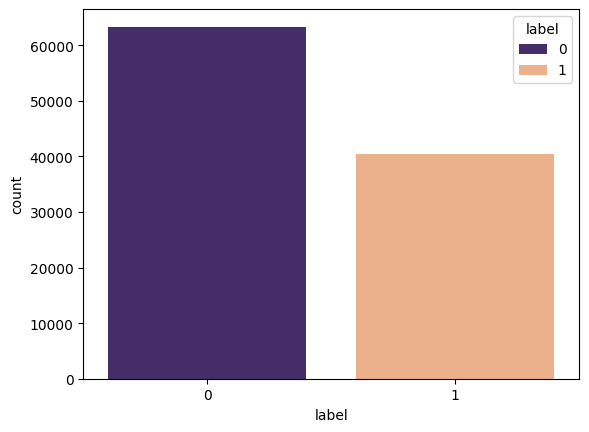

In [47]:
sns.countplot(x=counters['label'], palette=['#432371',"#FAAE7B"], hue=counters['label'])
print(counters['label'].value_counts())

## KNN

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import optuna

y = counters['label']
X = counters.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(X_train, y_train)
    accuracy = classifier_obj.score(X_test, y_test)
    return accuracy

knn_opt = optuna.create_study(direction='maximize')
knn_opt.optimize(objective, n_trials=1)


clf = KNeighborsClassifier(n_neighbors=knn_opt.best_trial.params['KNN_n_neighbors'])
clf.fit(X_train, y_train)

https://github.com/SulemanNavalur/Network-Intrusion-Detection/blob/main/CS.ipynb



[I 2024-05-29 06:36:22,082] A new study created in memory with name: no-name-a7c188f0-e0da-4e3d-b8d1-a792fa78d586
[I 2024-05-29 06:36:24,503] Trial 0 finished with value: 0.973324345146379 and parameters: {'KNN_n_neighbors': 2}. Best is trial 0 with value: 0.973324345146379.


FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.973324345146379], datetime_start=datetime.datetime(2024, 5, 29, 6, 36, 22, 83347), datetime_complete=datetime.datetime(2024, 5, 29, 6, 36, 24, 503361), params={'KNN_n_neighbors': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


## XD

In [ ]:
from sklearn.linear_model import LogisticRegression

y = counters['label']
X = counters.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression(max_iter=1200000)
clf.fit(X_train, y_train)